In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows=50
pd.options.display.max_columns=10

from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,4)
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
data=pd.read_excel("C:/Users/DELL/Untitled Folder 4/POCM_HISTORICAL.xlsx")

In [4]:
df=data[["Checkout_Date","Order_Quantity"]]
date = data[["Checkout_Date","Order_Quantity"]]

In [5]:
# data understanding
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160577 entries, 0 to 160576
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Checkout_Date   160577 non-null  datetime64[ns]
 1   Order_Quantity  160577 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.5 MB


In [6]:
df['Checkout_Date'].max() - df['Checkout_Date'].min()

Timedelta('528 days 00:00:00')

This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.

In [7]:
#Dealling with missing values if any 
df.isna().sum()

Checkout_Date     0
Order_Quantity    0
dtype: int64

#### Data understanding 

In [8]:
## weekly understanding
df['DayOfWeek'] = df['Checkout_Date'].dt.day_name()
print(df['DayOfWeek'])
df['month_name'] = df['Checkout_Date'].dt.month_name()
print(df['month_name'])

0           Tuesday
1           Tuesday
2         Wednesday
3         Wednesday
4         Wednesday
            ...    
160572       Friday
160573       Friday
160574       Friday
160575       Friday
160576       Friday
Name: DayOfWeek, Length: 160577, dtype: object
0         December
1         December
2         December
3         December
4         December
            ...   
160572         May
160573         May
160574         May
160575         May
160576         May
Name: month_name, Length: 160577, dtype: object


In [9]:
df.set_index('Checkout_Date',inplace=True)

In [10]:
df

,Order_Quantity,DayOfWeek,month_name
Checkout_Date,,,
2018-12-04,1,Tuesday,December
2018-12-04,1,Tuesday,December
2018-12-05,5,Wednesday,December
2018-12-05,10,Wednesday,December
2018-12-05,20,Wednesday,December
...,...,...,...
2020-05-15,5,Friday,May
2020-05-15,20,Friday,May
2020-05-15,2,Friday,May


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160577 entries, 2018-12-04 to 2020-05-15
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Order_Quantity  160577 non-null  int64 
 1   DayOfWeek       160577 non-null  object
 2   month_name      160577 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


In [12]:
#Understanding Weekly Order Quantity mean
weekly_df=df.resample('W').mean()

In [13]:
weekly_df

,Order_Quantity
Checkout_Date,
2018-12-09,9.408696
2018-12-16,15.907692
2018-12-23,15.570815
2018-12-30,13.138614
2019-01-06,17.648221
...,...
2020-04-19,9.014085
2020-04-26,7.211180
2020-05-03,8.304762


In [14]:
df.loc[df['Order_Quantity']>2000]

,Order_Quantity,DayOfWeek,month_name
Checkout_Date,,,
2019-04-03,3000,Wednesday,April
2019-04-03,3000,Wednesday,April
2019-04-03,2500,Wednesday,April
2019-04-03,2500,Wednesday,April
2019-04-03,3500,Wednesday,April
2019-04-03,3500,Wednesday,April
2019-04-03,3600,Wednesday,April
2019-12-06,2042,Friday,December


In [15]:
## As we want to forecast for 15 days of 2020
df['2020']


,Order_Quantity,DayOfWeek,month_name
Checkout_Date,,,
2020-01-01,12,Wednesday,January
2020-01-01,3,Wednesday,January
2020-01-02,10,Thursday,January
2020-01-02,30,Thursday,January
2020-01-02,12,Thursday,January
...,...,...,...
2020-05-15,5,Friday,May
2020-05-15,20,Friday,May
2020-05-15,2,Friday,May


In [16]:
df['2020-01':'2020-05']['Order_Quantity'].mean()

8.701769268056228

In [17]:
date = date.groupby(["Checkout_Date"])['Order_Quantity'].sum().reset_index()
date.head()

,Checkout_Date,Order_Quantity
0,2018-12-04,2
1,2018-12-05,79
2,2018-12-06,422
3,2018-12-07,468
4,2018-12-08,111


In [18]:
date=date[["Checkout_Date"]]

In [19]:
dummny_dates=pd.date_range(start='2018-12-04',end='2020-05-15')
dummny_dates=dummny_dates.to_frame(index = False)
dummny_dates.columns=["Checkout_Date"]
x = pd.concat([date, dummny_dates])
y = x.drop_duplicates(keep=False, inplace=False)
y['DayOfWeek'] = y['Checkout_Date'].dt.day_name()
y['month_name'] = y['Checkout_Date'].dt.month_name()
holidays=y.reset_index(drop=True)
holidays["DayOfWeek"].unique()

array(['Sunday', 'Saturday', 'Tuesday', 'Thursday'], dtype=object)

In [20]:
holidays

,Checkout_Date,DayOfWeek,month_name
0,2018-12-09,Sunday,December
1,2018-12-16,Sunday,December
2,2018-12-22,Saturday,December
3,2018-12-23,Sunday,December
4,2018-12-25,Tuesday,December
...,...,...,...
54,2020-04-25,Saturday,April
55,2020-05-02,Saturday,May
56,2020-05-03,Sunday,May
57,2020-05-09,Saturday,May


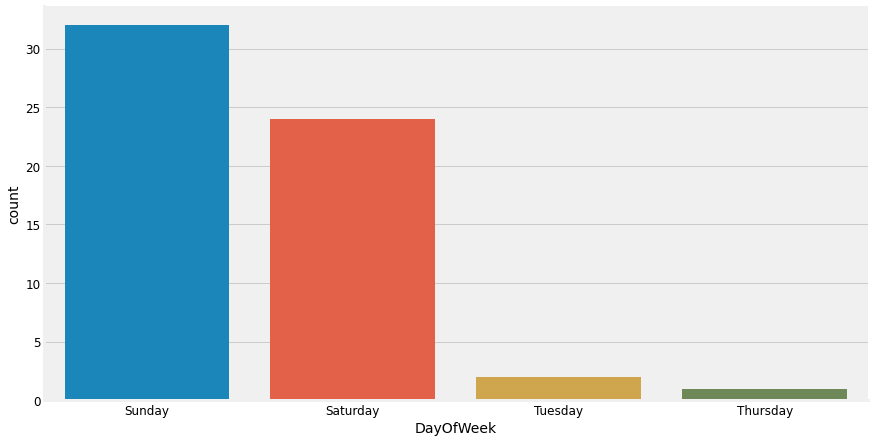

In [21]:
sns.catplot(x = 'DayOfWeek', data = holidays, kind = 'count',height=6,aspect=2)

In [22]:
## on the weekends our sale sis very high as comapared to the weekdays

In [23]:
#understanding the monthly weekdays count
daily_df = df.groupby(["Checkout_Date"])['Order_Quantity'].sum().reset_index()

daily_df.set_index("Checkout_Date", inplace=True)
daily_df.head(7)

,Order_Quantity
Checkout_Date,
2018-12-04,2
2018-12-05,79
2018-12-06,422
2018-12-07,468
2018-12-08,111
2018-12-10,914
2018-12-11,474


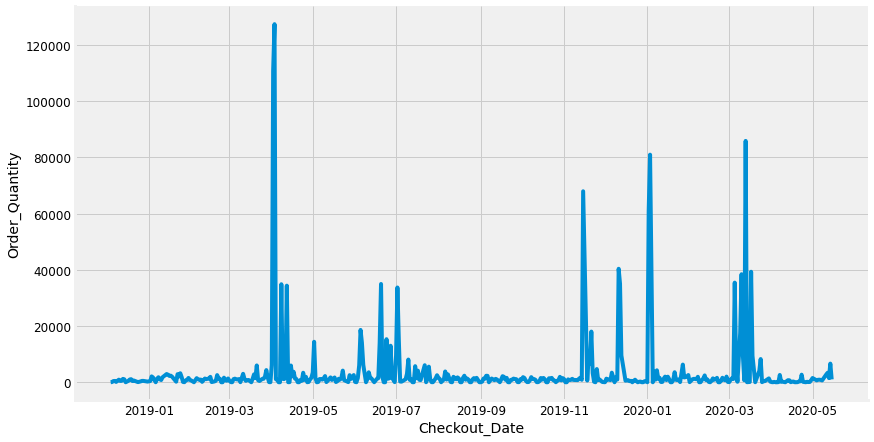

In [24]:
sns.relplot(x = 'Checkout_Date', y = 'Order_Quantity', data = daily_df, kind = 'line',height=6,aspect=2)

In [25]:
daily_df = daily_df.resample("D").mean().dropna()

### Data Preprocessing


Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

constant mean and mean is not time-dependent
constant variance and variance is not time-dependent
constant covariance and covariance is not time-dependent

#### 1 Augmented Dickey-Fuller (ADF)

Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

**p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
**p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

**ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [26]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Order_Quantity):
    result=adfuller(Order_Quantity)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

In [27]:
adfuller_test(daily_df['Order_Quantity'])

ADF Test Statistic : -10.14719787490447
p-value : 8.127120756465465e-18
#Lags Used : 2
Number of Observations Used : 467
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


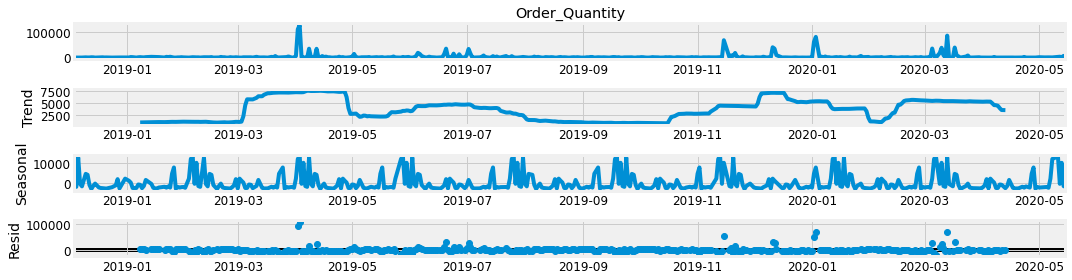

In [28]:
# understanding of the sesonality , trend , residual

from statsmodels.tsa.seasonal import seasonal_decompose
final = seasonal_decompose(daily_df['Order_Quantity'],model='additive', freq = 52) # annual=1,Quaterly=4,monthly=12,weekly=52
final.plot();

### Transforming the data 

In [29]:
# modeling 
from pmdarima import auto_arima
step_wise = auto_arima(np.log(daily_df["Order_Quantity"]), trace=True, suppress_warnings=True)
step_wise.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2072.289, Time=1.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2106.994, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2084.961, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2074.259, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3116.019, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2071.084, Time=0.62 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2071.032, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=2069.935, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2069.819, Time=1.12 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2038.630, Time=0.97 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=2036.559, Time=1.55 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2074.189, Time=0.56 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=2028.168, Time=1.56 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=2032.911, Time=1.52 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  470
Model:               SARIMAX(5, 0, 3)   Log Likelihood                -989.776
Date:                Tue, 15 Feb 2022   AIC                           1999.551
Time:                        11:46:35   BIC                           2041.078
Sample:                             0   HQIC                          2015.889
                                - 470                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.8227      0.711      2.563      0.010       0.429       3.217
ar.L1          1.5053      0.128     11.739      0.000       1.254       1.757
ar.L2         -1.5592      0.157     -9.940      0.000      -1.867      -1.252
ar.L3          0.9506      0.153      6.206      0.000       0.650       1.251
ar.L4         -0.5246      0.087     -6.007      0.000      -0.696      -0.353
ar.L5          0.3348      0.045      7.481      0.000       0.247       0.422
ma.L1         -1.3212      0.137     -9.667      0.000      -1.589      -1.053
ma.L2          1.1755      0.144      8.185      0.000       0.894       1.457
ma.L3         -0.4200      0.124     -3.394      0.001      -0.663      -0.177
sigma2         3.9867      0.237     16.849      0.000       3.523       4.450
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                29.43
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

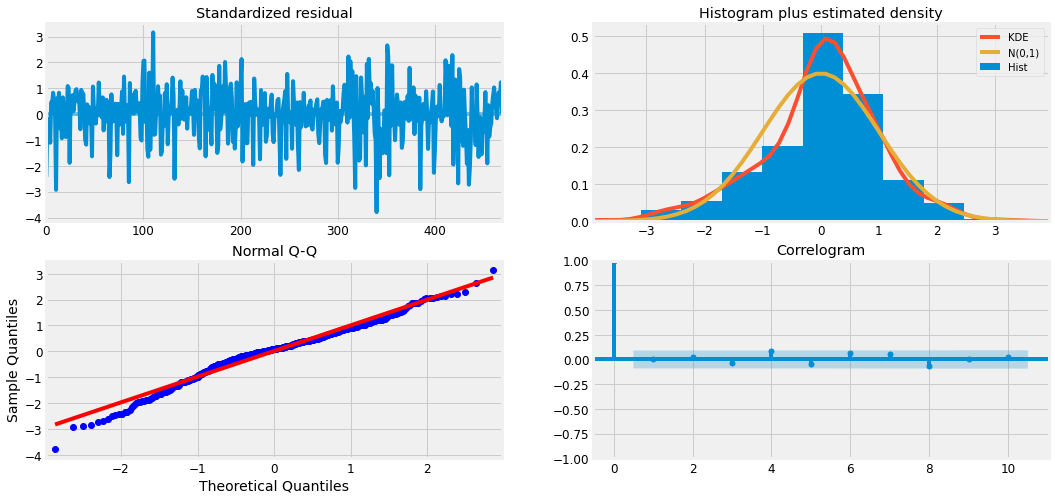

In [30]:
step_wise.plot_diagnostics(figsize=(16,8))
plt.show()

###### So how to interpret the plot diagnostics?

1. Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-3, 3).

2. Top Right: The density plot suggest normal distribution with mean zero.

3. Bottom left: The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed (not skewed for me).

4. Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

In [31]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
train = np.log(daily_df[:"2020-05-01"])
test = np.log(daily_df["2020-05-01":])
test

,Order_Quantity
Checkout_Date,
2020-05-01,7.315218
2020-05-04,6.519147
2020-05-05,6.777647
2020-05-06,6.820016
2020-05-07,6.716595
2020-05-08,6.480045
2020-05-11,7.918992
2020-05-12,8.121480
2020-05-13,7.307202


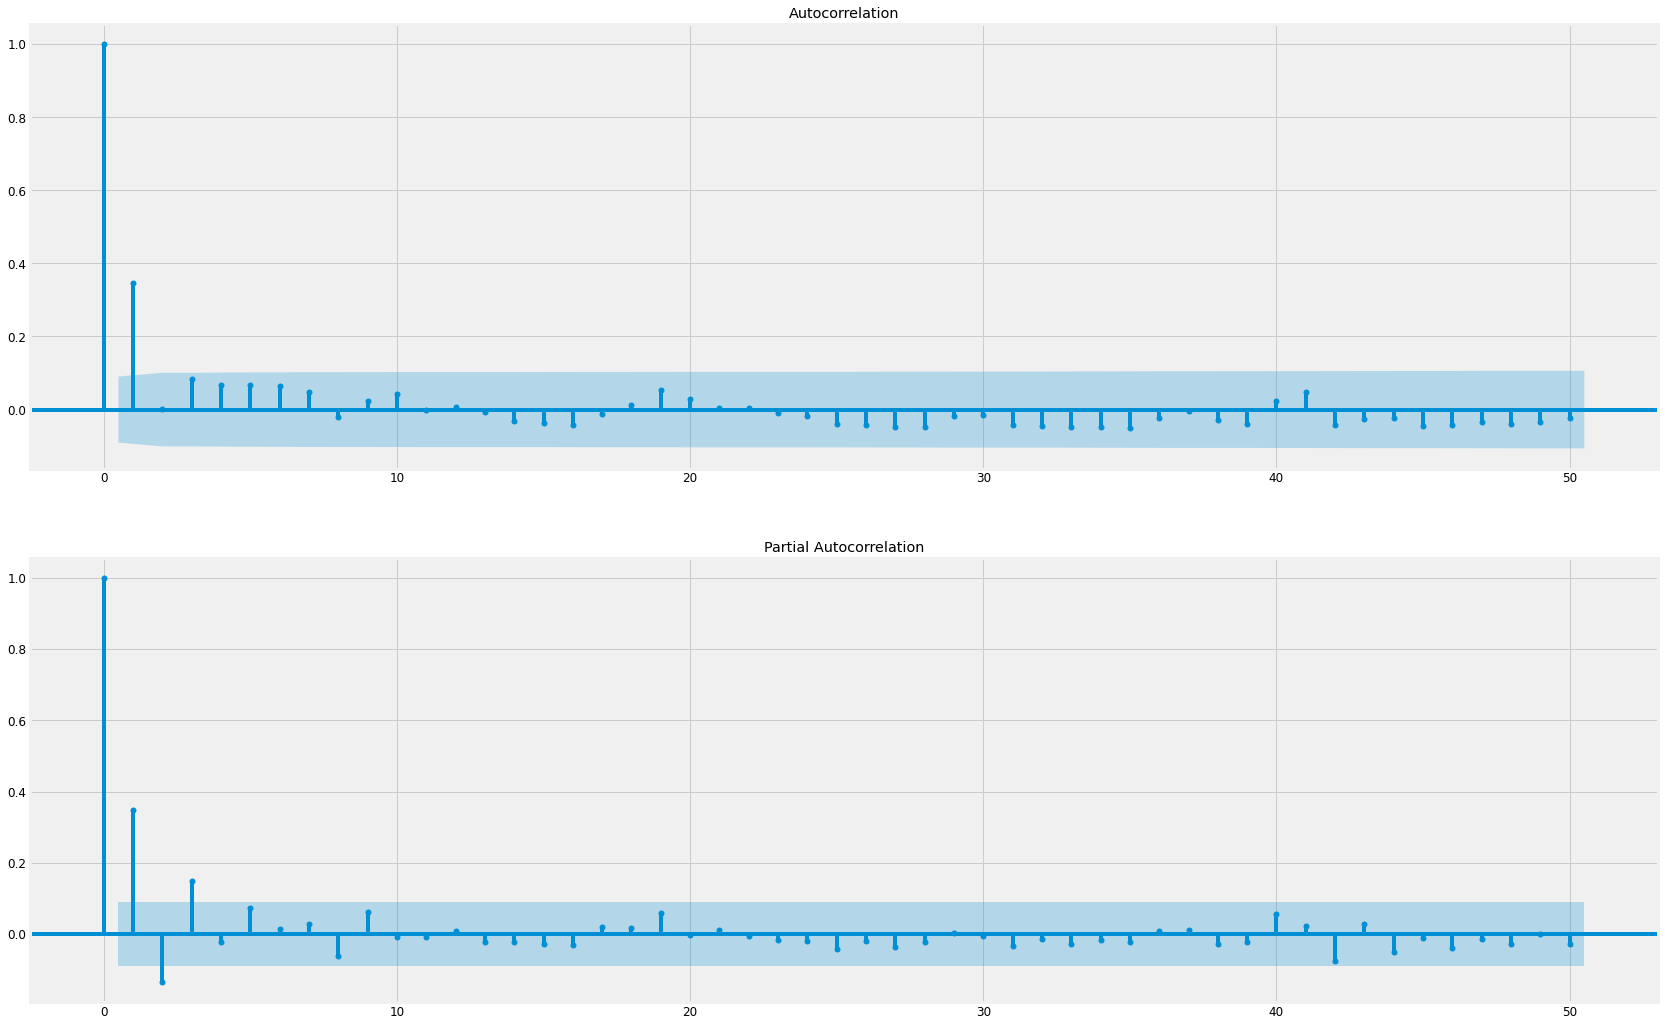

In [32]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(26, 18))

plot_acf(daily_df['Order_Quantity'], lags=50, ax=ax[0])
plot_pacf(daily_df['Order_Quantity'], lags=50, ax=ax[1])

plt.show()

##### Time series can be either univariate or multivariate:

Univariate time series only has a single time-dependent variable.
Here we are dealing with univarient

In [33]:
train.shape

(460, 1)

In [34]:
test.shape

(11, 1)

In [35]:
test

,Order_Quantity
Checkout_Date,
2020-05-01,7.315218
2020-05-04,6.519147
2020-05-05,6.777647
2020-05-06,6.820016
2020-05-07,6.716595
2020-05-08,6.480045
2020-05-11,7.918992
2020-05-12,8.121480
2020-05-13,7.307202


As we saw in the previous Steps, AutoARIMA (auto_arima) validates that (5,0,3) is the best configuration for (p,d,q).

In [36]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train["Order_Quantity"], order=(5,0,3))
model = model.fit()
model.summary()


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Order_Quantity   No. Observations:                  460
Model:                 ARIMA(5, 0, 3)   Log Likelihood                -970.832
Date:                Tue, 15 Feb 2022   AIC                           1961.665
Time:                        11:46:38   BIC                           2002.977
Sample:                             0   HQIC                          1977.933
                                - 460                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2017      0.176     35.157      0.000       5.856       6.547
ar.L1          1.5277      0.114     13.400      0.000       1.304       1.751
ar.L2         -1.5716      0.148    -10.620      0.000      -1.862      -1.282
ar.L3          0.9940      0.143      6.962      0.000       0.714       1.274
ar.L4         -0.5559      0.087     -6.359      0.000      -0.727      -0.385
ar.L5          0.3601      0.045      8.017      0.000       0.272       0.448
ma.L1         -1.3358      0.122    -10.910      0.000      -1.576      -1.096
ma.L2          1.1687      0.137      8.534      0.000       0.900       1.437
ma.L3         -0.4304      0.112     -3.860      0.000      -0.649      -0.212
sigma2         3.9753      0.236     16.854      0.000       3.513       4.438
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                28.32
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
#predictios
start = len(train)
stop = len(test) + len(train)-1
pred_arima = model.predict(start=start, end=stop)
pred_arima.index = daily_df.index[start-1:stop]
pred_arima

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Checkout_Date
2020-05-01    4.979602
2020-05-04    4.326722
2020-05-05    5.281134
2020-05-06    6.059067
2020-05-07    6.647258
2020-05-08    6.793672
2020-05-11    6.100505
2020-05-12    5.307380
2020-05-13    5.283868
2020-05-14    5.935886
2020-05-15    6.618609
Name: predicted_mean, dtype: float64

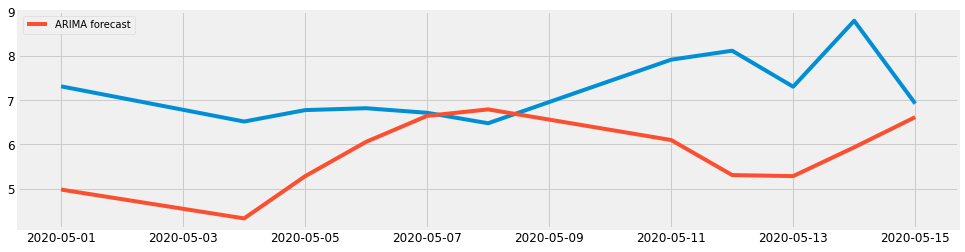

In [38]:
plt.plot(test)
plt.plot(pred_arima, label="ARIMA forecast")
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred_arima,test['Order_Quantity']))
print(rmse)

1.8290116606056757


In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarima=SARIMAX(train['Order_Quantity'],order=(5,0,3),seasonal_order=(5,0,3,15))
results_sarima = model_sarima.fit()
results_sarima.summary()

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Order_Quantity   No. Observations:                  460
Model:             SARIMAX(5, 0, 3)x(5, 0, 3, 15)   Log Likelihood               -1007.944
Date:                            Tue, 15 Feb 2022   AIC                           2049.887
Time:                                    11:48:05   BIC                           2120.118
Sample:                                         0   HQIC                          2077.543
                                            - 460                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1063      0.055     -1.931      0.054      -0.214       0.002
ar.L2          0.2378      0.065      3.685      0.000       0.111       0.364
ar.L3          0.8199      0.053     15.503      0.000       0.716       0.924
ar.L4         -0.1112      0.052     -2.128      0.033      -0.214      -0.009
ar.L5          0.1578      0.055      2.878      0.004       0.050       0.265
ma.L1          0.3706      0.037      9.914      0.000       0.297       0.444
ma.L2         -0.3134      0.039     -8.017      0.000      -0.390      -0.237
ma.L3         -0.9299      0.039    -24.034      0.000      -1.006      -0.854
ar.S.L15      -0.9087      0.146     -6.214      0.000      -1.195      -0.622
ar.S.L30       0.6787      0.188      3.614      0.000       0.311       1.047
ar.S.L45       0.9237      0.178      5.189      0.000       0.575       1.273
ar.S.L60       0.1889      0.078      2.433      0.015       0.037       0.341
ar.S.L75       0.1172      0.062      1.887      0.059      -0.005       0.239
ma.S.L15       0.7771      1.209      0.643      0.520      -1.593       3.147
ma.S.L30      -0.8520      2.151     -0.396      0.692      -5.069       3.365
ma.S.L45      -0.9209      1.131     -0.814      0.416      -3.137       1.296
sigma2         4.4984      5.126      0.878      0.380      -5.549      14.546
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                46.84
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
start = len(train)
stop = len(test) + len(train)-1
pred_sarima = results_sarima.predict(start=start, end=stop)
pred_sarima.index = daily_df.index[start-1:stop]
pred_sarima

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Checkout_Date
2020-05-01    5.128177
2020-05-04    5.704007
2020-05-05    6.038896
2020-05-06    5.922167
2020-05-07    5.563491
2020-05-08    5.498519
2020-05-11    4.995570
2020-05-12    5.923701
2020-05-13    6.145222
2020-05-14    6.395692
2020-05-15    5.385167
Name: predicted_mean, dtype: float64

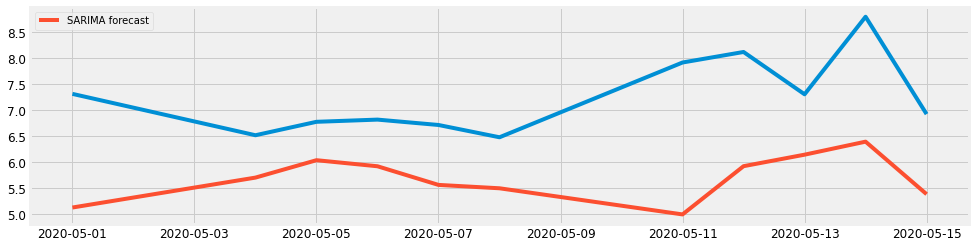

In [42]:
plt.plot(test)
plt.plot(pred_sarima, label="SARIMA forecast")
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred_sarima,test['Order_Quantity']))
print(rmse)

1.7048228028231127


In [44]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(train["Order_Quantity"])
model_ses = model.fit()
model_ses.summary()

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Dep. Variable:,Order_Quantity,No. Observations:,460
Model:,SimpleExpSmoothing,SSE,2399.060
Optimized:,True,AIC,763.739
Trend:,None,BIC,772.001
Seasonal:,None,AICC,763.827
Seasonal Periods:,None,Date:,"Tue, 15 Feb 2022"
Box-Cox:,False,Time:,11:48:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
initial_level,6.2247856,l.0,True


In [45]:
#predictios
start = len(train)
stop = len(test) + len(train)-1
pred_ses = model_ses.predict(start=start, end=stop)
pred_ses.index = daily_df.index[start-1:stop]
pred_ses

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Checkout_Date
2020-05-01    6.224786
2020-05-04    6.224786
2020-05-05    6.224786
2020-05-06    6.224786
2020-05-07    6.224786
2020-05-08    6.224786
2020-05-11    6.224786
2020-05-12    6.224786
2020-05-13    6.224786
2020-05-14    6.224786
2020-05-15    6.224786
dtype: float64

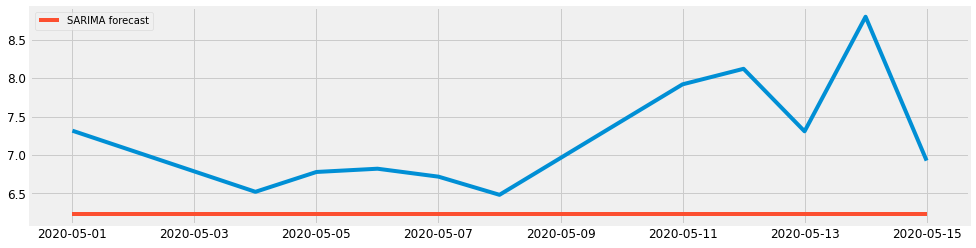

In [46]:
plt.plot(test)
plt.plot(pred_ses, label="SARIMA forecast")
plt.legend()
plt.show()

In [47]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred_ses,test['Order_Quantity']))
print(rmse)

1.2432522734663911


In [48]:
from statsmodels.tsa.api import Holt
fit1 = Holt(train['Order_Quantity']).fit(smoothing_level = 0.3,smoothing_slope = 0.25)

fit1.summary()


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Dep. Variable:,Order_Quantity,No. Observations:,460
Model:,Holt,SSE,3138.840
Optimized:,True,AIC,891.376
Trend:,Additive,BIC,907.901
Seasonal:,None,AICC,891.561
Seasonal Periods:,None,Date:,"Tue, 15 Feb 2022"
Box-Cox:,False,Time:,11:48:05
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3000000,alpha,False
smoothing_trend,0.2500000,beta,False


In [49]:
#predictios
start = len(train)
stop = len(test) + len(train)-1
pred_holt = fit1.predict(start=start, end=stop)
pred_holt.index = daily_df.index[start-1:stop]
pred_holt

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Checkout_Date
2020-05-01    6.060471
2020-05-04    6.331979
2020-05-05    6.603487
2020-05-06    6.874996
2020-05-07    7.146504
2020-05-08    7.418012
2020-05-11    7.689520
2020-05-12    7.961028
2020-05-13    8.232536
2020-05-14    8.504045
2020-05-15    8.775553
dtype: float64

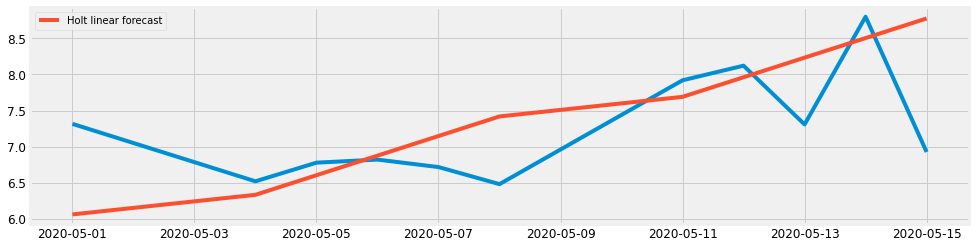

In [50]:
plt.plot(test)
plt.plot(pred_holt, label="Holt linear forecast")
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred_holt,test['Order_Quantity']))
print(rmse)

0.8063199535808728


In [52]:
from statsmodels.tsa.api import ExponentialSmoothing
fit_holt_winter = ExponentialSmoothing(train['Order_Quantity'] ,seasonal_periods=8,
                                       trend='add', seasonal='add').fit()
fit_holt_winter.summary()

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Dep. Variable:,Order_Quantity,No. Observations:,460
Model:,ExponentialSmoothing,SSE,2352.446
Optimized:,True,AIC,774.713
Trend:,Additive,BIC,824.287
Seasonal:,Additive,AICC,775.657
Seasonal Periods:,8,Date:,"Tue, 15 Feb 2022"
Box-Cox:,False,Time:,11:48:06
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,1.0832e-09,beta,True


In [53]:
#predictios
start = len(train)
stop = len(test) + len(train)-1
pred_holt_winter = fit_holt_winter.predict(start=start, end=stop)
pred_holt_winter.index = daily_df.index[start-1:stop]
pred_holt_winter

C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Checkout_Date
2020-05-01    6.071127
2020-05-04    6.164114
2020-05-05    6.363067
2020-05-06    5.937862
2020-05-07    5.588505
2020-05-08    5.467288
2020-05-11    5.988606
2020-05-12    5.892709
2020-05-13    6.061132
2020-05-14    6.154119
2020-05-15    6.353073
dtype: float64

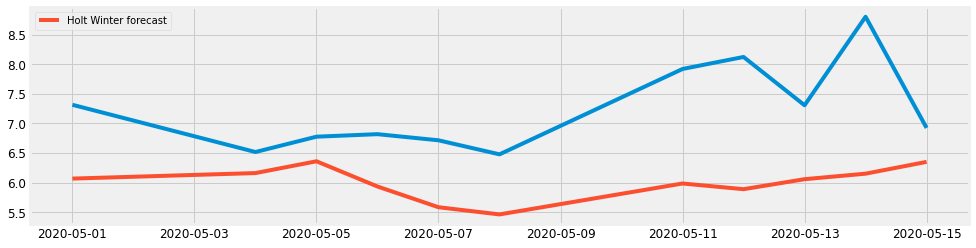

In [54]:
plt.plot(test)
plt.plot(pred_holt_winter, label="Holt Winter forecast")
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred_holt_winter,test['Order_Quantity']))
print(rmse)

1.430019898240067


In [56]:
## LSTM 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [57]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [58]:
scaled_train[:10]

array([[0.05896596],
       [0.37170847],
       [0.51424796],
       [0.52304955],
       [0.40063923],
       [0.57999212],
       [0.52413325],
       [0.5281641 ],
       [0.60364688],
       [0.59114195]])

In [59]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [60]:
# define generator
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [61]:
generator[0]

(array([[[0.05896596],
         [0.37170847],
         [0.51424796],
         [0.52304955],
         [0.40063923]]]),
 array([[0.57999212]]))

In [62]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [64]:
model = Sequential()
model.add(LSTM(100,activation="relu", input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

In [65]:
model.fit(generator, epochs=80)

Epoch 1/80
455/455 [==============================] - 2s 3ms/step - loss: 0.0479
Epoch 2/80
455/455 [==============================] - 1s 3ms/step - loss: 0.0394
Epoch 3/80
455/455 [==============================] - 1s 3ms/step - loss: 0.0377
Epoch 4/80
455/455 [==============================] - 1s 3ms/step - loss: 0.0373
Epoch 5/80
455/455 [==============================] - 1s 3ms/step - loss: 0.0360
Epoch 6/80
455/455 [==============================] - 1s 3ms/step - loss: 0.0357
Epoch 7/80
455/455 [==============================] - 2s 4ms/step - loss: 0.0369A: 0s - loss
Epoch 8/80
455/455 [==============================] - 1s 3ms/step - loss: 0.0354
Epoch 9/80
455/455 [==============================] - 1s 3ms/step - loss: 0.0346
Epoch 10/80
455/455 [==============================] - 1s 3ms/step - loss: 0.0351
Epoch 11/80
455/455 [==============================] - 1s 3ms/step - loss: 0.0346
Epoch 12/80
455/455 [==============================] - 1s 3ms/step - loss: 0.0335
Epoch 13/80
4

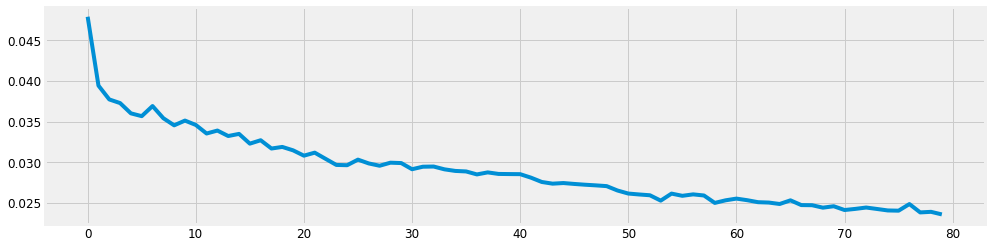

In [66]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [67]:
last_train_b = scaled_train[-n_input:]
last_train_b = last_train_b.reshape((1,n_input,n_features))
model.predict(last_train_b)

array([[0.5576631]], dtype=float32)

In [68]:
scaled_test[0]

array([0.62230485])

In [69]:
predictions = []

first_batch = scaled_train[-n_input:]
current_batch = first_batch.reshape((1,n_input,n_features))

for i in range(len(scaled_test)):
  #get the prediction values for first batch
  current_pred = model.predict(current_batch)[0]

  #append the prediction into array
  predictions.append(current_pred)

  #remove the first value
  curr_remv_val = current_batch[:,1:,:]

  #update the batch
  current_batch= np.append(curr_remv_val,[[current_pred]], axis=1)

In [70]:
predictions

[array([0.5576631], dtype=float32),
 array([0.5580398], dtype=float32),
 array([0.5353448], dtype=float32),
 array([0.38415855], dtype=float32),
 array([0.41681826], dtype=float32),
 array([0.5565287], dtype=float32),
 array([0.51387185], dtype=float32),
 array([0.54250115], dtype=float32),
 array([0.5639347], dtype=float32),
 array([0.50959086], dtype=float32),
 array([0.39046627], dtype=float32)]

In [71]:
test.head()

,Order_Quantity
Checkout_Date,
2020-05-01,7.315218
2020-05-04,6.519147
2020-05-05,6.777647
2020-05-06,6.820016
2020-05-07,6.716595


In [72]:
true_predictions = scaler.inverse_transform(predictions)

In [78]:
test['Predictions_LSTM'] = true_predictions

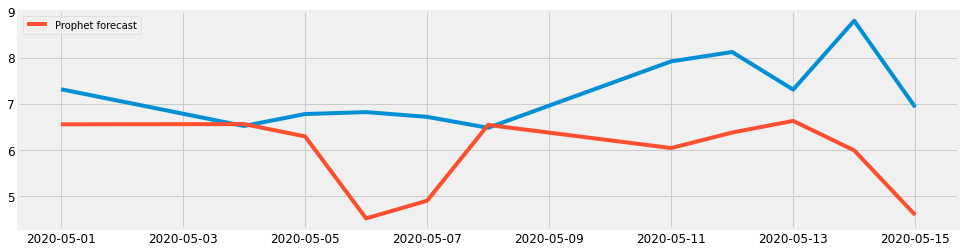

In [83]:
plt.plot(test['Order_Quantity'])
plt.plot(test['Predictions_LSTM'], label="Prophet forecast")
plt.legend()
plt.show()

In [84]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Predictions'],test['Order_Quantity']))
print(rmse)

1.646109417369499


In [85]:
predictions  = pd.DataFrame(test)

In [86]:
predictions


,Order_Quantity,Predictions,Predictions_LSTM
Checkout_Date,,,
2020-05-01,7.315218,6.555352,6.555352
2020-05-04,6.519147,6.559780,6.559780
2020-05-05,6.777647,6.292999,6.292999
2020-05-06,6.820016,4.515799,4.515799
2020-05-07,6.716595,4.899715,4.899715
2020-05-08,6.480045,6.542017,6.542017
2020-05-11,7.918992,6.040584,6.040584
2020-05-12,8.121480,6.377123,6.377123
2020-05-13,7.307202,6.629075,6.629075


In [90]:
predictions['Holt winter'] = pred_holt_winter
predictions['Holt Linear'] = pred_holt
predictions['SES'] = pred_ses
predictions['SARIMA'] = pred_sarima
predictions['ARIMA'] = pred_arima

In [94]:
predictions.pop("Predictions")

Checkout_Date
2020-05-01    6.555352
2020-05-04    6.559780
2020-05-05    6.292999
2020-05-06    4.515799
2020-05-07    4.899715
2020-05-08    6.542017
2020-05-11    6.040584
2020-05-12    6.377123
2020-05-13    6.629075
2020-05-14    5.990261
2020-05-15    4.589947
Name: Predictions, dtype: float64

In [95]:
predictions

,Order_Quantity,Predictions_LSTM,Holt winter,Holt LInear,Holt Linear,SES,SARIMA,ARIMA
Checkout_Date,,,,,,,,
2020-05-01,7.315218,6.555352,6.071127,6.060471,6.060471,6.224786,5.128177,4.979602
2020-05-04,6.519147,6.559780,6.164114,6.331979,6.331979,6.224786,5.704007,4.326722
2020-05-05,6.777647,6.292999,6.363067,6.603487,6.603487,6.224786,6.038896,5.281134
2020-05-06,6.820016,4.515799,5.937862,6.874996,6.874996,6.224786,5.922167,6.059067
2020-05-07,6.716595,4.899715,5.588505,7.146504,7.146504,6.224786,5.563491,6.647258
2020-05-08,6.480045,6.542017,5.467288,7.418012,7.418012,6.224786,5.498519,6.793672
2020-05-11,7.918992,6.040584,5.988606,7.689520,7.689520,6.224786,4.995570,6.100505
2020-05-12,8.121480,6.377123,5.892709,7.961028,7.961028,6.224786,5.923701,5.307380
2020-05-13,7.307202,6.629075,6.061132,8.232536,8.232536,6.224786,6.145222,5.283868


In [100]:
predictions.to_csv('prediction.csv', index=False,header=True)
new_df = pd.read_csv('prediction.csv')
print(new_df)

    Order_Quantity  Predictions_LSTM  Holt winter  Holt LInear  Holt Linear  \
0         7.315218          6.555352     6.071127     6.060471     6.060471   
1         6.519147          6.559780     6.164114     6.331979     6.331979   
2         6.777647          6.292999     6.363067     6.603487     6.603487   
3         6.820016          4.515799     5.937862     6.874996     6.874996   
4         6.716595          4.899715     5.588505     7.146504     7.146504   
5         6.480045          6.542017     5.467288     7.418012     7.418012   
6         7.918992          6.040584     5.988606     7.689520     7.689520   
7         8.121480          6.377123     5.892709     7.961028     7.961028   
8         7.307202          6.629075     6.061132     8.232536     8.232536   
9         8.799511          5.990261     6.154119     8.504045     8.504045   
10        6.925595          4.589947     6.353073     8.775553     8.775553   

         SES    SARIMA     ARIMA  
0   6.224786  5.